In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from mad import run_mad, select_pairs, order_scores

# Set up training data

In [2]:
# Load the csv
salinity = pd.read_csv('bottle.csv')
# Select only necessary collumns
salinity = salinity[['Salnty','T_degC' ]]
# Clean up
salinity.dropna(inplace=True)
# Select only a fraction
salinity = salinity[1500:2500]


# Plot the data

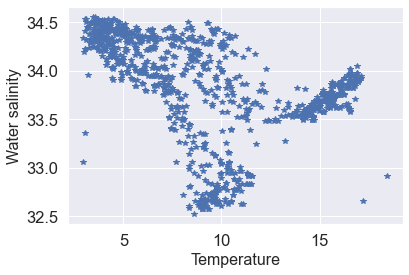

In [55]:
plt.figure()
plt.plot(salinity['T_degC'], salinity['Salnty'],'*')
plt.xlabel('Temperature', size=16)
plt.ylabel('Water salinity', size=16);

# Do the fitting

In [4]:
# Create train/validation split
train, validate = np.split(salinity.sample(frac=1, random_state=42),[int(.8*len(salinity))])
validate.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

y,X = train['Salnty'].values, train['T_degC'].values
yT, xT = validate['Salnty'].values, validate['T_degC'].values

validate = validate.drop(['T_degC'], axis=1)

In [5]:
# Fit polynomials
p1 = np.polyfit(X, y, deg=1)
p2 = np.polyfit(X, y, deg=2)
p3 = np.polyfit(X, y, deg=3)
p4 = np.polyfit(X, y, deg=4)
p5 = np.polyfit(X, y, deg=5)
p6 = np.polyfit(X, y, deg=6)

validate['first']  =  p1[1]+p1[0]*xT
validate['second'] =  p2[2]+p2[1]*xT+p2[0]*xT**2
validate['third']  =  p3[3]+p3[2]*xT+p3[1]*xT**2+p3[0]*xT**3
validate['forth']  =  p4[4]+p4[3]*xT+p4[2]*xT**2+p4[1]*xT**3+p4[0]*xT**4
validate['fifth']  =  p5[5]+p5[4]*xT+p5[3]*xT**2+p5[2]*xT**3+p5[1]*xT**4+p5[0]*xT**5
validate['sixth']  =  p6[6]+p6[5]*xT+p6[4]*xT**2+p6[3]*xT**3+p6[2]*xT**4+p6[1]*xT**5+p6[0]*xT**6

# Plot the fitting

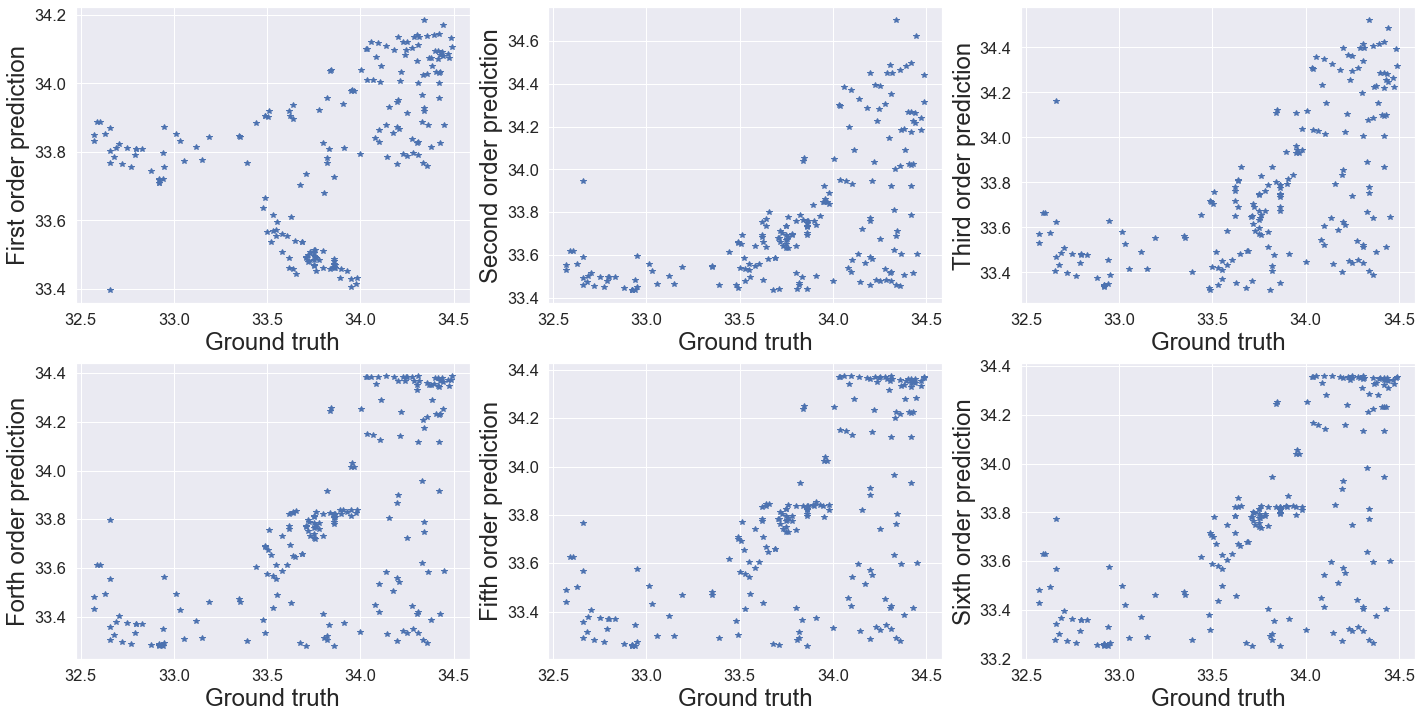

In [56]:
_, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24,12))

ax1.plot(validate['Salnty'],validate['first'],'*')
ax1.set_ylabel('First order prediction', size=24)
ax1.set_xlabel('Ground truth', size=24)
ax2.plot(validate['Salnty'],validate['second'],'*')
ax2.set_ylabel('Second order prediction', size=24)
ax2.set_xlabel('Ground truth', size=24)
ax3.plot(validate['Salnty'],validate['third'],'*')
ax3.set_ylabel('Third order prediction', size=24)
ax3.set_xlabel('Ground truth', size=24);
ax4.plot(validate['Salnty'],validate['forth'],'*')
ax4.set_ylabel('Forth order prediction', size=24)
ax4.set_xlabel('Ground truth', size=24);
ax5.plot(validate['Salnty'],validate['fifth'],'*')
ax5.set_ylabel('Fifth order prediction', size=24)
ax5.set_xlabel('Ground truth', size=24);
ax6.plot(validate['Salnty'],validate['sixth'],'*')
ax6.set_ylabel('Sixth order prediction', size=24)
ax6.set_xlabel('Ground truth', size=24);

# Perform MAD analysis

In [43]:
data_df = select_pairs(validate,'Salnty' )
result_array = run_mad(data_df, validate.columns, 'Salnty', numb_ex = 100, threshold_less = .2)

# Visualise example selected pairs

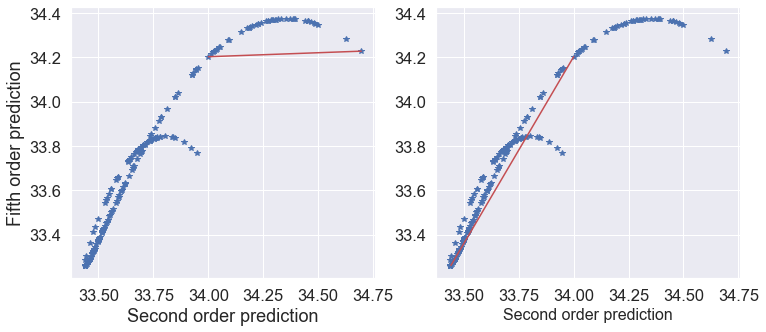

In [57]:
method_1 = 'second'
method_2 = 'fifth'

_,(ax1,ax2) = plt.subplots(1,2,  figsize=(12,5))
ax1.plot(validate[method_1], validate[method_2],'*')
for ii in range (0,1):
    data_df.sort_values(by=[method_1+'_'+method_2],ascending=False,inplace=True)
    data_df.reset_index(inplace= True, drop=True)

    # Find conditions that are close according to method 2
    data_df_slice = data_df.loc[abs(data_df[method_2])<1]
    data_df_slice.reset_index(inplace= True, drop=True)
    ax1.plot([validate[method_1][data_df['idx_1'][ii]],validate[method_1][data_df['idx_2'][ii]]],
             [validate[method_2][data_df['idx_1'][ii]],validate[method_2][data_df['idx_2'][ii]]],'r-')
    
ax1.set_xlabel('Second order prediction')
ax1.set_ylabel('Fifth order prediction')


method_1 = 'fifth'
method_2 = 'second'

ax2.plot(validate[method_2], validate[method_1],'*')
for ii in range (0,1):
    data_df.sort_values(by=[method_1+'_'+method_2],ascending=False,inplace=True)
    data_df.reset_index(inplace= True, drop=True)

    # Find conditions that are close according to method 2
    data_df_slice = data_df.loc[abs(data_df[method_2])<1]
    data_df_slice.reset_index(inplace= True, drop=True)
    ax2.plot([validate[method_2][data_df['idx_1'][ii]],validate[method_2][data_df['idx_2'][ii]]],
             [validate[method_1][data_df['idx_1'][ii]],validate[method_1][data_df['idx_2'][ii]]],'r-')
    
ax2.set_xlabel('Second order prediction', size=16);

# Pretify the output (sort the values in the heatmap)

In [45]:
methods = ['first', 'second','third', 'forth', 'fifth', 'sixth']
result_array_sorted, metrics_ordered =  order_scores(result_array,methods)

dict_mapping = {'first': 'First',
                'second': 'Second',
                'third':'Third',
                'forth':'Forth', 
                'fifth': 'Fifth',
                'sixth':'Sixth'}

def mapping_to_names(dict_of_mapping, list_of_methods):
    list_of_mappings = []
    for el in list_of_methods:
        list_of_mappings.append(dict_of_mapping[el])
        
    return list_of_mappings

list_of_mappings =  mapping_to_names(dict_mapping, metrics_ordered)

# Plot the histogram

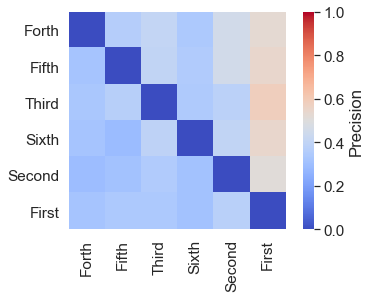

In [47]:
ax = sns.heatmap((result_array_sorted-np.diag(np.ones(len(methods))*0.5)), 
                 annot=False, 
                 square = True, 
                 cmap = "coolwarm",
                 xticklabels=list_of_mappings, 
                 yticklabels=list_of_mappings, 
                 cbar_kws={'label': 'Precision'}, 
                 vmin=.0, vmax=1)

sns.set(font_scale=1.5)

# Plot PSNR and SROCC

In [59]:
prediction_cols = ['first','second','third','forth', 'fifth', 'sixth']
rmse_array = []
plcc_array = []
for column in prediction_cols:   
    rmse_array.append(np.sqrt(np.mean((validate['Salnty'].values-validate[column].values)**2)))
    plcc_array.append(validate['Salnty'].corr(validate[column]))

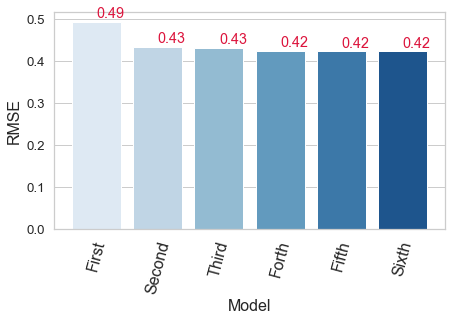

In [62]:
prediction_cols = ['First','Second','Third','Forth', 'Fifth', 'Sixth']
df = pd.DataFrame({'method':prediction_cols,
                   'RMSE':rmse_array,
                   'PLCC': plcc_array})

df = df.sort_values(by='RMSE', ascending =False)
df.reset_index(inplace =True, drop=True)

plt.figure(figsize=(7, 4))
sns.set(font_scale = 1.2,style="whitegrid")
g = sns.barplot(x = df['method'], y=df['RMSE'],palette="Blues", capsize=.15, errwidth = 2)
g.set_xticklabels(g.get_xticklabels(), rotation=75,  fontsize=16)
plt.errorbar(x=df['method'],y=df['RMSE'], fmt='none', c= 'k',
    capsize=6, 
    elinewidth=2,
    markeredgewidth=2)
plt.ylabel('RMSE',  fontsize=16)
plt.xlabel('Model',  fontsize=16)
jj = 0

for jj in range(0,len(prediction_cols)):

    g.text(jj,df['RMSE'].iloc[jj]+0.02, round(df['RMSE'].iloc[jj],2), color='crimson', ha="left", va = 'center')
    jj = jj+1


plt.show()

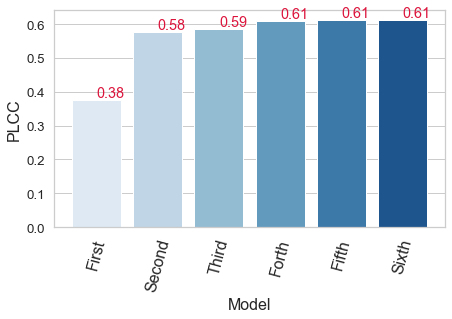

In [61]:
df = df.sort_values(by='PLCC', ascending =True)
df.reset_index(inplace =True, drop=True)

plt.figure(figsize=(7, 4))
sns.set(font_scale = 1.2,style="whitegrid")
g = sns.barplot(x = df['method'], y=df['PLCC'],palette="Blues", capsize=.15, errwidth = 2)
g.set_xticklabels(g.get_xticklabels(), rotation=75,  fontsize=16)
plt.errorbar(x=df['method'],y=df['PLCC'], fmt='none', c= 'k',
    capsize=6, 
    elinewidth=2,
    markeredgewidth=2)
plt.ylabel('PLCC',  fontsize=16)
plt.xlabel('Model',  fontsize=16)
jj = 0

for jj in range(0,len(prediction_cols)):

    g.text(jj,df['PLCC'].iloc[jj]+0.02, round(df['PLCC'].iloc[jj],2), color='crimson', ha="left", va = 'center')
    jj = jj+1


plt.show()